# Semantic Correspondence with DINOv2 Fine-Tuning

## Optimized Educational Implementation with Fine-Tuning Comparison

This notebook demonstrates semantic correspondence using DINOv2 features with fine-tuning on the SPair-71k dataset.

### Key Modifications (University Project Version):
1. **Optimized Data Loading**: Unzip dataset from Google Drive to local Colab storage for faster I/O
2. **Fine-Tuning Comparison**: Compare unfreezing 1 block vs 2 blocks of the transformer
3. **Comprehensive Visualizations**: Side-by-side comparison of both approaches

### What is Semantic Correspondence?
Given two images of the same object category (e.g., two different cats), semantic correspondence finds which point in the second image corresponds to a given point in the first image (e.g., "left eye" → "left eye").

---
# Part 0: Environment Setup and Data Loading Optimization
---

## 0.1 Environment Detection

In [1]:
# Detect if running in Google Colab or locally
import sys
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab environment")
except ImportError:
    IN_COLAB = False
    print("✓ Running in Local environment")

✓ Running in Google Colab environment


## 0.2 Mount Google Drive and Setup Paths

In [2]:
# Mount Google Drive (Colab) or set local path
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # OPTIMIZATION: Define separate paths for Drive (storage) and local (fast I/O)
    # Drive is used ONLY for: source zip file and saving results/checkpoints
    # Local /content is used for: training data (much faster I/O)
    DRIVE_ROOT = Path('/content/drive/MyDrive')
    LOCAL_ROOT = Path('/content')  # Fast local storage for training

    # Install dependencies
    !pip install -q torch torchvision timm tqdm scikit-image matplotlib opencv-python pandas
else:
    print('Running locally, skipping drive mount')
    # Local development uses the same path for everything
    DRIVE_ROOT = Path('./SemanticCorrespondence').resolve()
    LOCAL_ROOT = DRIVE_ROOT

DRIVE_ROOT.mkdir(exist_ok=True, parents=True)
print(f"✓ Drive root (for checkpoints/results): {DRIVE_ROOT}")
print(f"✓ Local root (for fast data access): {LOCAL_ROOT}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Drive root (for checkpoints/results): /content/drive/MyDrive
✓ Local root (for fast data access): /content


## 0.3 Data Loading Optimization: Unzip Dataset to Local Storage

### Why This Optimization Matters

Google Drive has **much slower I/O** than local Colab storage (`/content/`):
- **Drive I/O**: ~1-5 MB/s (network-dependent, high latency)
- **Local I/O**: ~100+ MB/s (SSD-like speeds)

For training with thousands of image pairs, this makes a **huge difference**:
- Training from Drive: ~30+ minutes per epoch
- Training from local: ~5-10 minutes per epoch

**Strategy**:
1. Keep the zip file on Drive (persistent storage)
2. Unzip to `/content/SPair-71k` at runtime (fast access)
3. Save checkpoints/results back to Drive (persistence)

In [3]:
# =============================================================================
# DATA LOADING OPTIMIZATION
# Unzip dataset from Drive to local Colab storage for faster I/O
# =============================================================================

import zipfile
import shutil
import time

def setup_optimized_dataset():
    """
    Unzip SPair-71k dataset from Google Drive to local Colab storage.

    This significantly speeds up training by using local SSD instead of
    network-based Google Drive access.

    Returns:
        Path: Path to the local dataset directory
    """

    if IN_COLAB:
        # Source: zip file on Google Drive
        drive_zip_path = DRIVE_ROOT / 'SPair-71k.zip'
        # Destination: local Colab storage (fast I/O)
        local_dataset_path = LOCAL_ROOT / 'SPair-71k'

        print("=" * 60)
        print("DATA LOADING OPTIMIZATION")
        print("=" * 60)

        # Check if already extracted (skip if exists and has expected structure)
        if local_dataset_path.exists():
            # Verify the dataset structure
            expected_dirs = ['JPEGImages', 'PairAnnotation']
            if all((local_dataset_path / d).exists() for d in expected_dirs):
                print(f"✓ Dataset already extracted at: {local_dataset_path}")
                # Quick check of dataset size
                num_images = len(list((local_dataset_path / 'JPEGImages').glob('*/*.jpg')))
                print(f"✓ Found {num_images} images")
                return local_dataset_path
            else:
                print("⚠ Incomplete extraction detected, re-extracting...")
                shutil.rmtree(local_dataset_path)

        # Check if zip file exists on Drive
        if not drive_zip_path.exists():
            raise FileNotFoundError(
                f"Dataset zip not found at: {drive_zip_path}\n"
                f"Please upload SPair-71k.zip to your Google Drive at:\n"
                f"  {DRIVE_ROOT}/SPair-71k.zip"
            )

        # Get zip file size for progress estimation
        zip_size_gb = drive_zip_path.stat().st_size / (1024**3)
        print(f"\nSource zip file: {drive_zip_path}")
        print(f"Zip file size: {zip_size_gb:.2f} GB")
        print(f"Destination: {local_dataset_path}")
        print("\nExtracting... (this takes 2-5 minutes)")

        # Extract with progress indication
        start_time = time.time()

        with zipfile.ZipFile(drive_zip_path, 'r') as zip_ref:
            # Get total number of files for progress
            total_files = len(zip_ref.namelist())
            print(f"Total files to extract: {total_files:,}")

            # Extract all files
            zip_ref.extractall(LOCAL_ROOT)

        elapsed_time = time.time() - start_time
        print(f"\n✓ Extraction complete in {elapsed_time:.1f} seconds")

        # Verify extraction
        if local_dataset_path.exists():
            num_images = len(list((local_dataset_path / 'JPEGImages').glob('*/*.jpg')))
            print(f"✓ Dataset ready at: {local_dataset_path}")
            print(f"✓ Found {num_images} images")
            return local_dataset_path
        else:
            raise RuntimeError("Extraction failed - dataset directory not found")

    else:
        # Local development - use Drive path directly
        local_path = DRIVE_ROOT / 'SPair-71k'
        if not local_path.exists():
            raise FileNotFoundError(f"Dataset not found at: {local_path}")
        print(f"✓ Using local dataset at: {local_path}")
        return local_path


# Execute the optimization
DATASET_PATH = setup_optimized_dataset()
print(f"\n{'='*60}")
print(f"DATASET_PATH = {DATASET_PATH}")
print(f"{'='*60}")

DATA LOADING OPTIMIZATION
✓ Dataset already extracted at: /content/SPair-71k
✓ Found 1800 images

DATASET_PATH = /content/SPair-71k


## 0.4 Clone DINOv2 Repository

In [4]:
# Clone DINOv2 repository if not present
DINO_PATH = DRIVE_ROOT / 'dinov2'
if not DINO_PATH.exists():
    if IN_COLAB:
        !git clone https://github.com/facebookresearch/dinov2.git {DINO_PATH} --depth 1
    else:
        import subprocess
        subprocess.run(['git', 'clone', 'https://github.com/facebookresearch/dinov2.git', str(DINO_PATH), '--depth', '1'])
    print("✓ DINOv2 cloned")
else:
    print("✓ DINOv2 found")

sys.path.append(str(DINO_PATH))

✓ DINOv2 found


---
# Part 1: Imports and Configuration
---

## 1.1 Imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import json
import hashlib
import pickle
from datetime import datetime
import random
import copy

print("✓ Imports complete")

✓ Imports complete


## 1.2 Configuration

All hyperparameters in one place for easy modification.

**Note**: `dataset_path` now points to the LOCAL extracted dataset for fast I/O, while results/checkpoints are saved to Drive.

In [6]:
# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    # Model settings
    'backbone_size': 'base',      # DINOv2 model size: 'small', 'base', or 'large'
    'image_size': 224,            # Input image size (224 is standard for ViT)
    'patch_size': 14,             # DINOv2 patch size (14x14 pixels per patch)
    'feature_layer': 9,           # Which transformer layer to extract features from (0-11)

    # Evaluation settings
    'batch_size': 32,              # Batch size for evaluation
    'max_samples': None,          # Set to a number to limit samples (e.g., 100 for testing)
    'pck_thresholds': [0.05, 0.1, 0.15, 0.2],  # PCK thresholds to evaluate

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Paths - OPTIMIZED: dataset_path uses LOCAL storage for fast I/O
    'dataset_path': DATASET_PATH,          # LOCAL path for fast training
    'cache_dir': DRIVE_ROOT / 'eval_cache', # DRIVE path for persistence
    'results_dir': DRIVE_ROOT / 'results',  # DRIVE path for results
    'checkpoint_dir': DRIVE_ROOT / 'checkpoints'  # DRIVE path for model checkpoints
}

# Fine-tuning configuration (shared between experiments)
FT_CONFIG = {
    # Training data
    'max_train_samples': None,     # None = use all training pairs

    # Training hyperparameters (SAME for both experiments for fair comparison)
    'learning_rate': 1e-5,         # Small learning rate for fine-tuning
    'epochs': 5,                   # Maximum epochs (early stopping may stop earlier)
    'batch_size': 32,               # Training batch size
    'temperature': 0.1,            # Temperature for softmax
    'weight_decay': 0.05,          # L2 regularization strength
    'label_smoothing': 0.1,        # Label smoothing for cross-entropy

    # Regularization
    'warmup_steps': 100,           # Learning rate warmup steps
    'max_grad_norm': 1.0,          # Gradient clipping threshold

    # Data augmentation
    'use_augmentation': True,      # Enable data augmentation during training
    'horizontal_flip_prob': 0.5,   # Probability of horizontal flip
    'color_jitter': 0.2,           # Color jittering strength

    # Early stopping
    'use_early_stopping': True,
    'patience': 2,                 # Stop after N epochs without improvement
    'min_delta': 0.001,            # Minimum improvement to count as progress

    'device': CONFIG['device']
}

# Create directories
CONFIG['cache_dir'].mkdir(exist_ok=True, parents=True)
CONFIG['results_dir'].mkdir(exist_ok=True, parents=True)
CONFIG['checkpoint_dir'].mkdir(exist_ok=True, parents=True)

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")
print(f"\nDevice: {CONFIG['device']}")
print(f"\n⚡ Data loaded from: {CONFIG['dataset_path']} (optimized local storage)")
print(f"💾 Results saved to: {CONFIG['results_dir']} (persistent Drive storage)")

Configuration:
  backbone_size: base
  image_size: 224
  patch_size: 14
  feature_layer: 9
  batch_size: 32
  max_samples: None
  pck_thresholds: [0.05, 0.1, 0.15, 0.2]
  device: cuda
  dataset_path: /content/SPair-71k
  cache_dir: /content/drive/MyDrive/eval_cache
  results_dir: /content/drive/MyDrive/results
  checkpoint_dir: /content/drive/MyDrive/checkpoints

Device: cuda

⚡ Data loaded from: /content/SPair-71k (optimized local storage)
💾 Results saved to: /content/drive/MyDrive/results (persistent Drive storage)


---
# Part 2: Dataset and Model Classes
---

## 2.1 Dataset Class

In [7]:
class SPairDataset(Dataset):
    """
    SPair-71k Dataset for Semantic Correspondence.

    Loads image pairs and keypoint annotations directly from the PairAnnotation directory.
    """

    def __init__(self, root_dir, split='test', image_size=224, max_samples=None, augment=False):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.augment = augment and (split == 'train')

        # Map split names to directory names
        split_map = {'train': 'trn', 'val': 'val', 'test': 'test'}
        split_name = split_map.get(split, split)

        # Load annotations
        anno_dir = self.root_dir / 'PairAnnotation' / split_name

        if not anno_dir.exists():
            raise FileNotFoundError(f"Annotation directory not found: {anno_dir}")

        print(f"Loading annotations from {anno_dir}...")
        self.annotation_files = sorted(list(anno_dir.glob('*.json')))

        if max_samples:
            self.annotation_files = self.annotation_files[:max_samples]

        # Pre-load and validate annotations
        self.annotations = []
        category_count = {}

        for json_file in tqdm(self.annotation_files, desc="Validating annotations"):
            try:
                with open(json_file, 'r') as f:
                    anno = json.load(f)

                src_img = anno.get('src_imname', '')
                tgt_img = anno.get('trg_imname', '') or anno.get('tgt_imname', '')
                category = anno.get('category', '')

                if not all([src_img, tgt_img, category]):
                    continue

                src_path = self.root_dir / 'JPEGImages' / category / src_img
                tgt_path = self.root_dir / 'JPEGImages' / category / tgt_img

                if src_path.exists() and tgt_path.exists():
                    self.annotations.append({
                        'json_path': json_file,
                        'src_img': src_img,
                        'tgt_img': tgt_img,
                        'category': category
                    })
                    category_count[category] = category_count.get(category, 0) + 1
            except Exception:
                continue

        print(f"✓ Loaded {len(self.annotations)} valid pairs from {split}")
        print(f"✓ Categories ({len(category_count)}): {', '.join(sorted(category_count.keys()))}")

        # Setup augmentation
        if self.augment:
            self.color_jitter = T.ColorJitter(
                brightness=FT_CONFIG['color_jitter'],
                contrast=FT_CONFIG['color_jitter'],
                saturation=FT_CONFIG['color_jitter'],
                hue=FT_CONFIG['color_jitter'] / 2
            )

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno_info = self.annotations[idx]

        with open(anno_info['json_path'], 'r') as f:
            anno = json.load(f)

        # Load images
        src_path = self.root_dir / 'JPEGImages' / anno_info['category'] / anno_info['src_img']
        tgt_path = self.root_dir / 'JPEGImages' / anno_info['category'] / anno_info['tgt_img']

        src_img = Image.open(src_path).convert('RGB')
        tgt_img = Image.open(tgt_path).convert('RGB')

        src_orig_size = src_img.size
        tgt_orig_size = tgt_img.size

        # Load keypoints
        src_kps = np.array(anno['src_kps'], dtype=np.float32)
        tgt_kps = np.array(anno.get('trg_kps', anno.get('tgt_kps')), dtype=np.float32)

        # Augmentation
        do_flip = self.augment and random.random() < FT_CONFIG['horizontal_flip_prob']

        if do_flip:
            src_img = src_img.transpose(Image.FLIP_LEFT_RIGHT)
            tgt_img = tgt_img.transpose(Image.FLIP_LEFT_RIGHT)
            src_kps[:, 0] = src_orig_size[0] - 1 - src_kps[:, 0]
            tgt_kps[:, 0] = tgt_orig_size[0] - 1 - tgt_kps[:, 0]

        if self.augment:
            src_img = self.color_jitter(src_img)
            tgt_img = self.color_jitter(tgt_img)

        # Resize
        src_img = src_img.resize((self.image_size, self.image_size), Image.BILINEAR)
        tgt_img = tgt_img.resize((self.image_size, self.image_size), Image.BILINEAR)

        # Scale keypoints
        src_kps[:, 0] = src_kps[:, 0] * self.image_size / src_orig_size[0]
        src_kps[:, 1] = src_kps[:, 1] * self.image_size / src_orig_size[1]
        tgt_kps[:, 0] = tgt_kps[:, 0] * self.image_size / tgt_orig_size[0]
        tgt_kps[:, 1] = tgt_kps[:, 1] * self.image_size / tgt_orig_size[1]

        # Valid mask
        valid = np.array([
            (s[0] >= 0 and s[1] >= 0 and t[0] >= 0 and t[1] >= 0)
            for s, t in zip(src_kps, tgt_kps)
        ], dtype=bool)

        # Convert to tensors
        src_tensor = self._to_tensor(src_img)
        tgt_tensor = self._to_tensor(tgt_img)

        return {
            'src_img': src_tensor,
            'tgt_img': tgt_tensor,
            'src_kps': torch.from_numpy(src_kps),
            'tgt_kps': torch.from_numpy(tgt_kps),
            'valid': torch.from_numpy(valid),
            'category': anno_info['category']
        }

    def _to_tensor(self, img):
        tensor = torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.0
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return (tensor - mean) / std

## 2.2 Load DINOv2 Model

In [8]:
def load_dinov2(size='base', device='cuda'):
    """
    Load pretrained DINOv2 model.
    """
    model_names = {
        'small': 'dinov2_vits14',
        'base': 'dinov2_vitb14',
        'large': 'dinov2_vitl14'
    }

    print(f"Loading {model_names[size]}...")
    model = torch.hub.load('facebookresearch/dinov2', model_names[size], trust_repo=True)
    model = model.to(device)
    model.eval()
    print(f"✓ Model loaded ({sum(p.numel() for p in model.parameters()):,} parameters)")
    return model

# Load the backbone model for baseline evaluation
backbone = load_dinov2(CONFIG['backbone_size'], CONFIG['device'])

Loading dinov2_vitb14...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


✓ Model loaded (86,580,480 parameters)


## 2.3 Feature Extractor

In [9]:
class FeatureExtractor:
    """
    Extract spatial features from DINOv2.
    """

    def __init__(self, model, patch_size=14, device='cuda'):
        self.model = model
        self.patch_size = patch_size
        self.device = device
        self.hook_output = None

    def _hook(self, module, input, output):
        self.hook_output = output

    def extract(self, img, layer_idx=None):
        B, C, H, W = img.shape

        H_adj = (H // self.patch_size) * self.patch_size
        W_adj = (W // self.patch_size) * self.patch_size
        if H != H_adj or W != W_adj:
            img = F.interpolate(img, size=(H_adj, W_adj), mode='bilinear', align_corners=False)

        hook = None
        if layer_idx is not None:
            hook = self.model.blocks[layer_idx].register_forward_hook(self._hook)

        out = self.model.forward_features(img)

        if layer_idx is not None and self.hook_output is not None:
            features = self.hook_output[:, 1:]
            hook.remove()
            self.hook_output = None
        else:
            features = out['x_norm_patchtokens']

        H_feat = H_adj // self.patch_size
        W_feat = W_adj // self.patch_size
        D = features.shape[-1]

        features = features.reshape(B, H_feat, W_feat, D)
        features = F.normalize(features, p=2, dim=-1)

        return features

## 2.4 Correspondence Finding and PCK Metric

In [10]:
def find_correspondences(src_feats, tgt_feats, src_kps_list, patch_size=14):
    """
    Find correspondences using nearest neighbor search.
    """
    B, H, W, D = src_feats.shape
    pred_kps_list = []

    for b in range(B):
        src_kps = src_kps_list[b]
        num_kps = src_kps.shape[0]

        src_kps_grid = (src_kps / patch_size).long()
        src_kps_grid[:, 0] = torch.clamp(src_kps_grid[:, 0], 0, W - 1)
        src_kps_grid[:, 1] = torch.clamp(src_kps_grid[:, 1], 0, H - 1)

        tgt_flat = tgt_feats[b].reshape(-1, D)
        pred_kps = torch.zeros_like(src_kps)

        for k in range(num_kps):
            x_grid = src_kps_grid[k, 0]
            y_grid = src_kps_grid[k, 1]
            src_vec = src_feats[b, y_grid, x_grid]
            similarities = torch.matmul(src_vec, tgt_flat.T)
            best_idx = torch.argmax(similarities)
            y_pred = best_idx // W
            x_pred = best_idx % W
            pred_kps[k, 0] = x_pred * patch_size + patch_size // 2
            pred_kps[k, 1] = y_pred * patch_size + patch_size // 2

        pred_kps_list.append(pred_kps)

    return pred_kps_list


def compute_pck(pred_kps, gt_kps, valid, thresholds, img_size):
    """
    Compute Percentage of Correct Keypoints (PCK).
    """
    results = {}

    for alpha in thresholds:
        threshold_pixels = alpha * img_size
        correct = 0
        total = 0

        for b in range(len(pred_kps)):
            for k in range(len(pred_kps[b])):
                if not valid[b][k]:
                    continue
                dist = torch.norm(pred_kps[b][k].float() - gt_kps[b][k].float()).item()
                if dist <= threshold_pixels:
                    correct += 1
                total += 1

        pck = (correct / total * 100) if total > 0 else 0.0
        results[f'PCK@{alpha}'] = pck

    return results

## 2.5 Evaluation Function

In [11]:
def evaluate(model, config, tag=None, use_cache=True):
    """
    Evaluate model on the test set.
    """
    print("\n" + "=" * 60)
    print(f"EVALUATION{f' ({tag})' if tag else ''}")
    print("=" * 60)

    print("\nRunning full evaluation...")

    dataset = SPairDataset(
        config['dataset_path'],
        split='test',
        image_size=config['image_size'],
        max_samples=config['max_samples']
    )

    # Custom collate function to handle variable-length keypoints
    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch], # Keep as list
            'tgt_kps': [item['tgt_kps'] for item in batch], # Keep as list
            'valid': [item['valid'] for item in batch],     # Keep as list
            'category': [item['category'] for item in batch] # Keep as list
        }

    loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0, collate_fn=collate_fn)
    extractor = FeatureExtractor(model, config['patch_size'], config['device'])

    all_preds = []
    all_gts = []
    all_valids = []
    all_cats = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            src_img = batch['src_img'].to(config['device'])
            tgt_img = batch['tgt_img'].to(config['device'])
            # Items are now lists of tensors/strings
            src_kps = [kp.to(config['device']) for kp in batch['src_kps']]
            tgt_kps = batch['tgt_kps']
            valid = batch['valid']

            src_feats = extractor.extract(src_img, layer_idx=config['feature_layer'])
            tgt_feats = extractor.extract(tgt_img, layer_idx=config['feature_layer'])

            pred_kps = find_correspondences(src_feats, tgt_feats, src_kps, config['patch_size'])

            for i in range(len(pred_kps)):
                all_preds.append(pred_kps[i].cpu())
                all_gts.append(tgt_kps[i])
                all_valids.append(valid[i])
                all_cats.append(batch['category'][i])

    # Compute overall PCK
    pck_overall = compute_pck(all_preds, all_gts, all_valids, config['pck_thresholds'], config['image_size'])

    print("\nOverall Results:")
    for threshold, pck in pck_overall.items():
        print(f"  {threshold}: {pck:.2f}%")

    # Per-category
    unique_cats = sorted(set(all_cats))
    pck_by_cat = {}
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        cat_preds = [all_preds[i] for i in cat_indices]
        cat_gts = [all_gts[i] for i in cat_indices]
        cat_valids = [all_valids[i] for i in cat_indices]
        if cat_preds:
            pck_by_cat[cat] = compute_pck(cat_preds, cat_gts, cat_valids, config['pck_thresholds'], config['image_size'])

    print("\nPer-Category Results (PCK@0.1):")
    for cat in unique_cats:
        print(f"  {cat}: {pck_by_cat[cat]['PCK@0.1']:.1f}%")

    return {
        'overall': pck_overall,
        'categories': pck_by_cat,
        'predictions': all_preds,
        'ground_truth': all_gts,
        'valid': all_valids,
        'categories_list': all_cats
    }

## 2.6 Run Baseline Evaluation

In [12]:
# Evaluate baseline model (no fine-tuning)
results_baseline = evaluate(backbone, CONFIG, tag='baseline')


EVALUATION (baseline)

Running full evaluation...
Loading annotations from /content/SPair-71k/PairAnnotation/test...


Validating annotations: 100%|██████████| 12234/12234 [00:00<00:00, 12732.80it/s]


✓ Loaded 12234 valid pairs from test
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor


Evaluating: 100%|██████████| 383/383 [04:59<00:00,  1.28it/s]



Overall Results:
  PCK@0.05: 30.95%
  PCK@0.1: 51.88%
  PCK@0.15: 63.17%
  PCK@0.2: 70.97%

Per-Category Results (PCK@0.1):
  aeroplane: 56.8%
  bicycle: 52.9%
  bird: 82.3%
  boat: 36.3%
  bottle: 36.4%
  bus: 39.6%
  car: 42.8%
  cat: 68.3%
  chair: 35.1%
  cow: 63.5%
  dog: 64.3%
  horse: 58.9%
  motorbike: 43.7%
  person: 62.7%
  pottedplant: 40.9%
  sheep: 58.1%
  train: 53.4%
  tvmonitor: 34.9%


---
# Part 3: Fine-Tuning with Comparison

## Experiment Design

We compare two fine-tuning strategies:

| Experiment | Unfrozen Blocks | Trainable Params | Hypothesis |
|------------|-----------------|------------------|------------|
| **1 Block** | Block 11 only | ~8% | Conservative, less overfitting risk |
| **2 Blocks** | Blocks 10-11 | ~16% | More capacity, potentially better adaptation |

**Key Question**: Does unfreezing more blocks improve performance, or does it lead to overfitting?

---

## 3.1 Loss Function

In [13]:
def correspondence_loss(src_feats, tgt_feats, src_kps, tgt_kps, valid, temperature=0.1, label_smoothing=0.0):
    """
    Cross-Entropy Loss for Semantic Correspondence.
    Treats correspondence as classification over the spatial grid.
    """
    B, H, W, D = src_feats.shape
    patch_size = CONFIG['patch_size']

    total_loss = 0.0
    num_valid_samples = 0

    for b in range(B):
        mask = valid[b]
        if not mask.any():
            continue

        src_kp = src_kps[b][mask]
        tgt_kp = tgt_kps[b][mask]

        src_grid = (src_kp / patch_size).long()
        tgt_grid = (tgt_kp / patch_size).long()

        src_grid[:, 0] = torch.clamp(src_grid[:, 0], 0, W - 1)
        src_grid[:, 1] = torch.clamp(src_grid[:, 1], 0, H - 1)
        tgt_grid[:, 0] = torch.clamp(tgt_grid[:, 0], 0, W - 1)
        tgt_grid[:, 1] = torch.clamp(tgt_grid[:, 1], 0, H - 1)

        src_flat = src_feats[b].reshape(-1, D)
        tgt_flat = tgt_feats[b].reshape(-1, D)

        src_indices = src_grid[:, 1] * W + src_grid[:, 0]
        tgt_indices = tgt_grid[:, 1] * W + tgt_grid[:, 0]

        src_vecs = src_flat[src_indices]
        logits = torch.matmul(src_vecs, tgt_flat.T) / temperature

        loss = F.cross_entropy(logits, tgt_indices, label_smoothing=label_smoothing)

        total_loss += loss
        num_valid_samples += 1

    if num_valid_samples > 0:
        return total_loss / num_valid_samples
    else:
        return torch.tensor(0.0, device=src_feats.device, requires_grad=True)

print("✓ Loss function defined")

✓ Loss function defined


## 3.2 Fine-Tuning Setup Functions

In [14]:
def unfreeze_last_n_blocks(model, n_blocks=1):
    """
    Unfreeze only the last N transformer blocks for fine-tuning.

    Strategy:
    - Early layers capture low-level features (edges, textures) - keep frozen
    - Later layers capture high-level semantics - fine-tune these

    Args:
        model: DINOv2 model
        n_blocks: Number of blocks to unfreeze from the end

    Returns:
        model: Model with updated requires_grad settings
        trainable_params: Number of trainable parameters
    """
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # Get total number of transformer blocks
    total_blocks = len(model.blocks)
    start_idx = total_blocks - n_blocks

    print(f"Model has {total_blocks} transformer blocks")
    print(f"Unfreezing blocks {start_idx} to {total_blocks-1} ({n_blocks} blocks)")

    # Unfreeze the last N blocks
    for i in range(start_idx, total_blocks):
        for param in model.blocks[i].parameters():
            param.requires_grad = True

    # Also unfreeze the final layer norm
    if hasattr(model, 'norm'):
        for param in model.norm.parameters():
            param.requires_grad = True
        print("Also unfreezing final norm layer")

    # Count parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())

    print(f"\nTrainable: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

    return model, trainable

print("✓ Fine-tuning setup functions defined")

✓ Fine-tuning setup functions defined


## 3.3 Generalized Training Function

This function can train with any number of unfrozen blocks.

In [15]:
def train_finetune(n_blocks=1, experiment_name="experiment"):
    """
    Fine-tune DINOv2 for semantic correspondence.

    Args:
        n_blocks: Number of transformer blocks to unfreeze
        experiment_name: Name for logging and checkpoints

    Returns:
        model: Fine-tuned model
        history: Dict with training and validation losses
        trainable_params: Number of trainable parameters
    """
    print("\n" + "=" * 70)
    print(f"FINE-TUNING: {experiment_name.upper()}")
    print(f"Unfreezing last {n_blocks} block(s)")
    print("=" * 70)

    # Load fresh model
    model = load_dinov2(CONFIG['backbone_size'], CONFIG['device'])

    # Unfreeze specified number of blocks
    model, trainable_params = unfreeze_last_n_blocks(model, n_blocks)

    # Load datasets
    print("\nLoading datasets...")
    train_dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='train',
        image_size=CONFIG['image_size'],
        max_samples=FT_CONFIG['max_train_samples'],
        augment=FT_CONFIG['use_augmentation']
    )

    val_dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='val',
        image_size=CONFIG['image_size'],
        augment=False
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch]
        }

    train_loader = DataLoader(
        train_dataset,
        batch_size=FT_CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=8,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=FT_CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    # Optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=FT_CONFIG['learning_rate'],
        weight_decay=FT_CONFIG['weight_decay']
    )

    # Learning rate scheduler
    total_steps = len(train_loader) * FT_CONFIG['epochs']
    warmup_steps = FT_CONFIG['warmup_steps']

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.1, 1.0 - (step - warmup_steps) / (total_steps - warmup_steps))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Feature extractor
    extractor = FeatureExtractor(model, CONFIG['patch_size'], CONFIG['device'])

    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print(f"\nTraining for up to {FT_CONFIG['epochs']} epochs")
    print(f"Early stopping: patience={FT_CONFIG['patience']}")
    print("-" * 70)

    for epoch in range(FT_CONFIG['epochs']):
        # === Training ===
        model.train()
        epoch_train_loss = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{FT_CONFIG['epochs']} [Train]")
        for batch in pbar:
            optimizer.zero_grad()

            src_img = batch['src_img'].to(CONFIG['device'])
            tgt_img = batch['tgt_img'].to(CONFIG['device'])
            src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
            valid = [v.to(CONFIG['device']) for v in batch['valid']]

            src_feats = extractor.extract(src_img, layer_idx=None)
            tgt_feats = extractor.extract(tgt_img, layer_idx=None)

            loss = correspondence_loss(
                src_feats, tgt_feats,
                src_kps, tgt_kps, valid,
                temperature=FT_CONFIG['temperature'],
                label_smoothing=FT_CONFIG['label_smoothing']
            )

            loss.backward()

            torch.nn.utils.clip_grad_norm_(
                filter(lambda p: p.requires_grad, model.parameters()),
                FT_CONFIG['max_grad_norm']
            )

            optimizer.step()
            scheduler.step()

            epoch_train_loss.append(loss.item())
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        avg_train_loss = sum(epoch_train_loss) / len(epoch_train_loss)
        train_losses.append(avg_train_loss)

        # === Validation ===
        model.eval()
        epoch_val_loss = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{FT_CONFIG['epochs']} [Val]", leave=False):
                src_img = batch['src_img'].to(CONFIG['device'])
                tgt_img = batch['tgt_img'].to(CONFIG['device'])
                src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
                tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
                valid = [v.to(CONFIG['device']) for v in batch['valid']]

                src_feats = extractor.extract(src_img, layer_idx=None)
                tgt_feats = extractor.extract(tgt_img, layer_idx=None)

                loss = correspondence_loss(
                    src_feats, tgt_feats,
                    src_kps, tgt_kps, valid,
                    temperature=FT_CONFIG['temperature'],
                    label_smoothing=0.0
                )
                epoch_val_loss.append(loss.item())

        avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")

        # === Early Stopping ===
        if FT_CONFIG['use_early_stopping']:
            if avg_val_loss < best_val_loss - FT_CONFIG['min_delta']:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                print(f"  → New best model (val_loss={best_val_loss:.4f})")
            else:
                patience_counter += 1
                print(f"  → No improvement ({patience_counter}/{FT_CONFIG['patience']})")

                if patience_counter >= FT_CONFIG['patience']:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Restored best model (val_loss={best_val_loss:.4f})")

    # Save checkpoint to Drive
    checkpoint_path = CONFIG['checkpoint_dir'] / f'{experiment_name}_best.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'n_blocks': n_blocks,
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses
    }, checkpoint_path)
    print(f"✓ Checkpoint saved to: {checkpoint_path}")

    print("\n" + "=" * 70)
    print(f"FINE-TUNING COMPLETE: {experiment_name.upper()}")
    print("=" * 70)

    return model, {'train': train_losses, 'val': val_losses}, trainable_params

print("✓ Training function defined")

✓ Training function defined


---
## 3.4 Run Fine-Tuning Experiments

### Experiment 1: Unfreeze Last 1 Block
---

In [16]:
# =============================================================================
# EXPERIMENT 1: Fine-tune with 1 block unfrozen
# =============================================================================

model_1block, history_1block, params_1block = train_finetune(
    n_blocks=1,
    experiment_name="finetune_1block"
)


FINE-TUNING: FINETUNE_1BLOCK
Unfreezing last 1 block(s)
Loading dinov2_vitb14...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✓ Model loaded (86,580,480 parameters)
Model has 12 transformer blocks
Unfreezing blocks 11 to 11 (1 blocks)
Also unfreezing final norm layer

Trainable: 7,090,944 / 86,580,480 (8.2%)

Loading datasets...
Loading annotations from /content/SPair-71k/PairAnnotation/trn...


Validating annotations: 100%|██████████| 53340/53340 [00:04<00:00, 11980.02it/s]


✓ Loaded 53340 valid pairs from train
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor
Loading annotations from /content/SPair-71k/PairAnnotation/val...


Validating annotations: 100%|██████████| 5384/5384 [00:00<00:00, 12767.75it/s]


✓ Loaded 5384 valid pairs from val
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor

Training for up to 5 epochs
Early stopping: patience=2
----------------------------------------------------------------------


Epoch 1/5 [Train]: 100%|██████████| 1667/1667 [15:13<00:00,  1.83it/s, loss=2.4954]


Epoch 1: Train=2.8923, Val=2.6262
  → New best model (val_loss=2.6262)


Epoch 2/5 [Train]: 100%|██████████| 1667/1667 [15:14<00:00,  1.82it/s, loss=1.9950]


Epoch 2: Train=2.1465, Val=2.7554
  → No improvement (1/2)


Epoch 3/5 [Train]: 100%|██████████| 1667/1667 [15:14<00:00,  1.82it/s, loss=1.8076]


Epoch 3: Train=1.8250, Val=2.9842
  → No improvement (2/2)

Early stopping at epoch 3

✓ Restored best model (val_loss=2.6262)
✓ Checkpoint saved to: /content/drive/MyDrive/checkpoints/finetune_1block_best.pth

FINE-TUNING COMPLETE: FINETUNE_1BLOCK


### Experiment 2: Unfreeze Last 2 Blocks

In [17]:
# =============================================================================
# EXPERIMENT 2: Fine-tune with 2 blocks unfrozen
# =============================================================================

model_2blocks, history_2blocks, params_2blocks = train_finetune(
    n_blocks=2,
    experiment_name="finetune_2blocks"
)


FINE-TUNING: FINETUNE_2BLOCKS
Unfreezing last 2 block(s)
Loading dinov2_vitb14...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✓ Model loaded (86,580,480 parameters)
Model has 12 transformer blocks
Unfreezing blocks 10 to 11 (2 blocks)
Also unfreezing final norm layer

Trainable: 14,180,352 / 86,580,480 (16.4%)

Loading datasets...
Loading annotations from /content/SPair-71k/PairAnnotation/trn...


Validating annotations: 100%|██████████| 53340/53340 [00:04<00:00, 12045.42it/s]


✓ Loaded 53340 valid pairs from train
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor
Loading annotations from /content/SPair-71k/PairAnnotation/val...


Validating annotations: 100%|██████████| 5384/5384 [00:00<00:00, 12724.72it/s]


✓ Loaded 5384 valid pairs from val
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor

Training for up to 5 epochs
Early stopping: patience=2
----------------------------------------------------------------------


Epoch 1/5 [Train]: 100%|██████████| 1667/1667 [16:54<00:00,  1.64it/s, loss=1.4552]


Epoch 1: Train=2.2381, Val=3.1821
  → New best model (val_loss=3.1821)


Epoch 2/5 [Train]: 100%|██████████| 1667/1667 [16:54<00:00,  1.64it/s, loss=1.1123]


Epoch 2: Train=1.3153, Val=4.7807
  → No improvement (1/2)


Epoch 3/5 [Train]: 100%|██████████| 1667/1667 [16:54<00:00,  1.64it/s, loss=1.1101]


Epoch 3: Train=1.1275, Val=5.3577
  → No improvement (2/2)

Early stopping at epoch 3

✓ Restored best model (val_loss=3.1821)
✓ Checkpoint saved to: /content/drive/MyDrive/checkpoints/finetune_2blocks_best.pth

FINE-TUNING COMPLETE: FINETUNE_2BLOCKS


## 3.5 Plot Training Curves Comparison

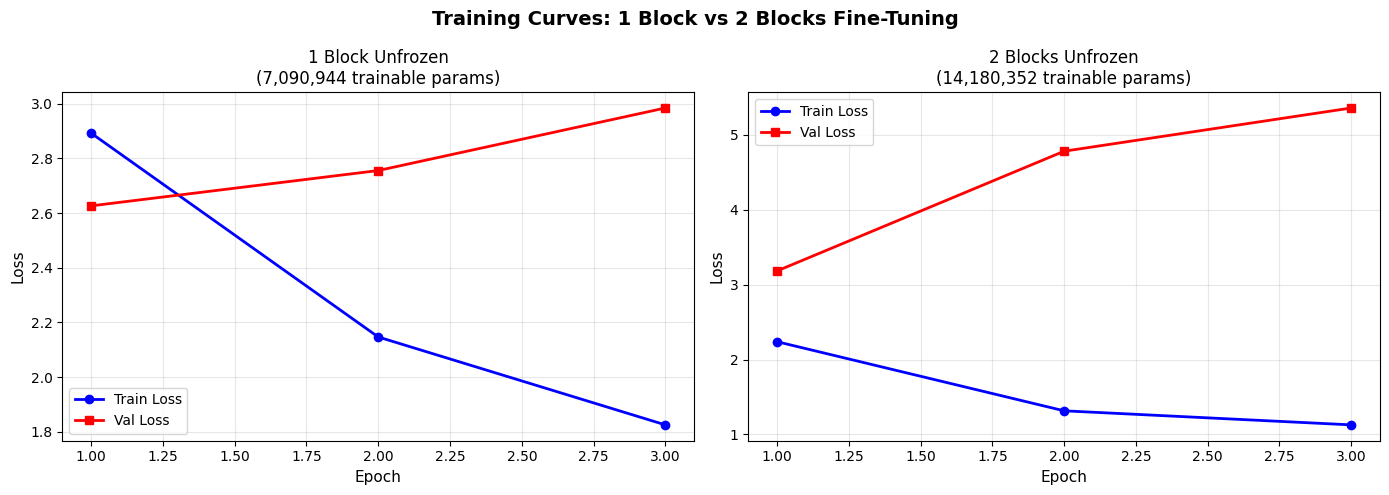


1 Block - Final Train: 1.8250, Val: 2.9842
2 Blocks - Final Train: 1.1275, Val: 5.3577


In [18]:
# =============================================================================
# TRAINING CURVES COMPARISON
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Experiment 1: 1 Block
ax1 = axes[0]
epochs_1 = range(1, len(history_1block['train']) + 1)
ax1.plot(epochs_1, history_1block['train'], 'b-o', label='Train Loss', linewidth=2)
ax1.plot(epochs_1, history_1block['val'], 'r-s', label='Val Loss', linewidth=2)
ax1.set_title(f"1 Block Unfrozen\n({params_1block:,} trainable params)", fontsize=12)
ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Loss", fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Experiment 2: 2 Blocks
ax2 = axes[1]
epochs_2 = range(1, len(history_2blocks['train']) + 1)
ax2.plot(epochs_2, history_2blocks['train'], 'b-o', label='Train Loss', linewidth=2)
ax2.plot(epochs_2, history_2blocks['val'], 'r-s', label='Val Loss', linewidth=2)
ax2.set_title(f"2 Blocks Unfrozen\n({params_2blocks:,} trainable params)", fontsize=12)
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("Loss", fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle("Training Curves: 1 Block vs 2 Blocks Fine-Tuning", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(CONFIG['results_dir'] / 'training_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n1 Block - Final Train: {history_1block['train'][-1]:.4f}, Val: {history_1block['val'][-1]:.4f}")
print(f"2 Blocks - Final Train: {history_2blocks['train'][-1]:.4f}, Val: {history_2blocks['val'][-1]:.4f}")

---
# Part 4: Evaluate and Compare Both Models
---

## 4.1 Evaluate Both Fine-Tuned Models

In [19]:
# Create config for fine-tuned model evaluation (use final layer)
FT_EVAL_CONFIG = CONFIG.copy()
FT_EVAL_CONFIG['feature_layer'] = None  # Use final layer output

# Evaluate 1-block model
print("\n" + "#" * 70)
print("# EVALUATING 1-BLOCK FINE-TUNED MODEL")
print("#" * 70)
results_1block = evaluate(model_1block, FT_EVAL_CONFIG, tag='finetuned_1block')

# Evaluate 2-block model
print("\n" + "#" * 70)
print("# EVALUATING 2-BLOCK FINE-TUNED MODEL")
print("#" * 70)
results_2blocks = evaluate(model_2blocks, FT_EVAL_CONFIG, tag='finetuned_2blocks')


######################################################################
# EVALUATING 1-BLOCK FINE-TUNED MODEL
######################################################################

EVALUATION (finetuned_1block)

Running full evaluation...
Loading annotations from /content/SPair-71k/PairAnnotation/test...


Validating annotations: 100%|██████████| 12234/12234 [00:00<00:00, 12992.56it/s]


✓ Loaded 12234 valid pairs from test
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor


Evaluating: 100%|██████████| 383/383 [04:57<00:00,  1.29it/s]



Overall Results:
  PCK@0.05: 49.37%
  PCK@0.1: 70.31%
  PCK@0.15: 79.34%
  PCK@0.2: 85.06%

Per-Category Results (PCK@0.1):
  aeroplane: 71.8%
  bicycle: 70.3%
  bird: 86.9%
  boat: 56.8%
  bottle: 57.6%
  bus: 70.4%
  car: 66.1%
  cat: 82.1%
  chair: 53.2%
  cow: 80.3%
  dog: 78.8%
  horse: 80.0%
  motorbike: 70.5%
  person: 72.5%
  pottedplant: 60.2%
  sheep: 74.1%
  train: 71.1%
  tvmonitor: 60.3%

######################################################################
# EVALUATING 2-BLOCK FINE-TUNED MODEL
######################################################################

EVALUATION (finetuned_2blocks)

Running full evaluation...
Loading annotations from /content/SPair-71k/PairAnnotation/test...


Validating annotations: 100%|██████████| 12234/12234 [00:00<00:00, 12839.78it/s]


✓ Loaded 12234 valid pairs from test
✓ Categories (18): aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor


Evaluating: 100%|██████████| 383/383 [04:55<00:00,  1.30it/s]



Overall Results:
  PCK@0.05: 49.62%
  PCK@0.1: 69.56%
  PCK@0.15: 77.83%
  PCK@0.2: 82.88%

Per-Category Results (PCK@0.1):
  aeroplane: 71.4%
  bicycle: 62.9%
  bird: 85.4%
  boat: 51.8%
  bottle: 53.2%
  bus: 72.9%
  car: 66.5%
  cat: 84.1%
  chair: 55.9%
  cow: 82.3%
  dog: 75.7%
  horse: 77.2%
  motorbike: 57.7%
  person: 68.4%
  pottedplant: 48.1%
  sheep: 71.6%
  train: 81.2%
  tvmonitor: 65.3%


## 4.2 Side-by-Side PCK Comparison

In [20]:
# =============================================================================
# COMPREHENSIVE COMPARISON TABLE
# =============================================================================

print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON: BASELINE vs 1-BLOCK vs 2-BLOCKS FINE-TUNING")
print("=" * 80)

# Create comparison DataFrame
comparison_data = []

for threshold in CONFIG['pck_thresholds']:
    key = f'PCK@{threshold}'
    baseline_val = results_baseline['overall'][key]
    one_block_val = results_1block['overall'][key]
    two_blocks_val = results_2blocks['overall'][key]

    comparison_data.append({
        'Threshold': threshold,
        'Baseline': baseline_val,
        '1 Block': one_block_val,
        '2 Blocks': two_blocks_val,
        'Δ(1B-Base)': one_block_val - baseline_val,
        'Δ(2B-Base)': two_blocks_val - baseline_val,
        'Δ(2B-1B)': two_blocks_val - one_block_val,
        'Best': '2 Blocks' if two_blocks_val > one_block_val else '1 Block'
    })

df_comparison = pd.DataFrame(comparison_data)

print("\nPCK Comparison:")
print(df_comparison.to_string(index=False, float_format='%.2f'))

# Summary statistics
print("\n" + "-" * 80)
print("MODEL CONFIGURATION SUMMARY")
print("-" * 80)
print(f"{'Model':<20} {'Trainable Params':<20} {'% of Total':<15} {'Best Val Loss':<15}")
print(f"{'Baseline':<20} {'0 (frozen)':<20} {'0%':<15} {'N/A':<15}")
print(f"{'1 Block':<20} {f'{params_1block:,}':<20} {f'{100*params_1block/86580480:.1f}%':<15} {f'{min(history_1block["val"]):.4f}':<15}")
print(f"{'2 Blocks':<20} {f'{params_2blocks:,}':<20} {f'{100*params_2blocks/86580480:.1f}%':<15} {f'{min(history_2blocks["val"]):.4f}':<15}")


COMPREHENSIVE COMPARISON: BASELINE vs 1-BLOCK vs 2-BLOCKS FINE-TUNING

PCK Comparison:
 Threshold  Baseline  1 Block  2 Blocks  Δ(1B-Base)  Δ(2B-Base)  Δ(2B-1B)     Best
      0.05     30.95    49.37     49.62       18.42       18.67      0.25 2 Blocks
      0.10     51.88    70.31     69.56       18.43       17.68     -0.75  1 Block
      0.15     63.17    79.34     77.83       16.17       14.66     -1.50  1 Block
      0.20     70.97    85.06     82.88       14.10       11.92     -2.18  1 Block

--------------------------------------------------------------------------------
MODEL CONFIGURATION SUMMARY
--------------------------------------------------------------------------------
Model                Trainable Params     % of Total      Best Val Loss  
Baseline             0 (frozen)           0%              N/A            
1 Block              7,090,944            8.2%            2.6262         
2 Blocks             14,180,352           16.4%           3.1821         


## 4.3 Per-Category Comparison

In [21]:
# =============================================================================
# PER-CATEGORY COMPARISON
# =============================================================================

print("\n" + "=" * 80)
print("PER-CATEGORY COMPARISON (PCK@0.1)")
print("=" * 80)

categories = sorted(results_baseline['categories'].keys())
category_comparison = []

for cat in categories:
    baseline_pck = results_baseline['categories'][cat]['PCK@0.1']
    one_block_pck = results_1block['categories'][cat]['PCK@0.1']
    two_blocks_pck = results_2blocks['categories'][cat]['PCK@0.1']

    category_comparison.append({
        'Category': cat,
        'Baseline': baseline_pck,
        '1 Block': one_block_pck,
        '2 Blocks': two_blocks_pck,
        'Δ(1B)': one_block_pck - baseline_pck,
        'Δ(2B)': two_blocks_pck - baseline_pck,
        'Best FT': '2B' if two_blocks_pck > one_block_pck else '1B'
    })

df_category = pd.DataFrame(category_comparison)
print("\n" + df_category.to_string(index=False, float_format='%.1f'))

# Count wins
wins_1b = sum(1 for row in category_comparison if row['1 Block'] > row['2 Blocks'])
wins_2b = sum(1 for row in category_comparison if row['2 Blocks'] > row['1 Block'])
ties = len(categories) - wins_1b - wins_2b

print(f"\n{'='*80}")
print(f"Category Wins: 1 Block={wins_1b}, 2 Blocks={wins_2b}, Ties={ties}")
print(f"{'='*80}")


PER-CATEGORY COMPARISON (PCK@0.1)

   Category  Baseline  1 Block  2 Blocks  Δ(1B)  Δ(2B) Best FT
  aeroplane      56.8     71.8      71.4   15.0   14.6      1B
    bicycle      52.9     70.3      62.9   17.4   10.0      1B
       bird      82.3     86.9      85.4    4.6    3.1      1B
       boat      36.3     56.8      51.8   20.5   15.5      1B
     bottle      36.4     57.6      53.2   21.3   16.9      1B
        bus      39.6     70.4      72.9   30.8   33.3      2B
        car      42.8     66.1      66.5   23.3   23.6      2B
        cat      68.3     82.1      84.1   13.7   15.7      2B
      chair      35.1     53.2      55.9   18.1   20.8      2B
        cow      63.5     80.3      82.3   16.9   18.8      2B
        dog      64.3     78.8      75.7   14.5   11.3      1B
      horse      58.9     80.0      77.2   21.1   18.2      1B
  motorbike      43.7     70.5      57.7   26.8   14.0      1B
     person      62.7     72.5      68.4    9.8    5.6      1B
pottedplant      40

## 4.4 Visualization: Bar Chart Comparison

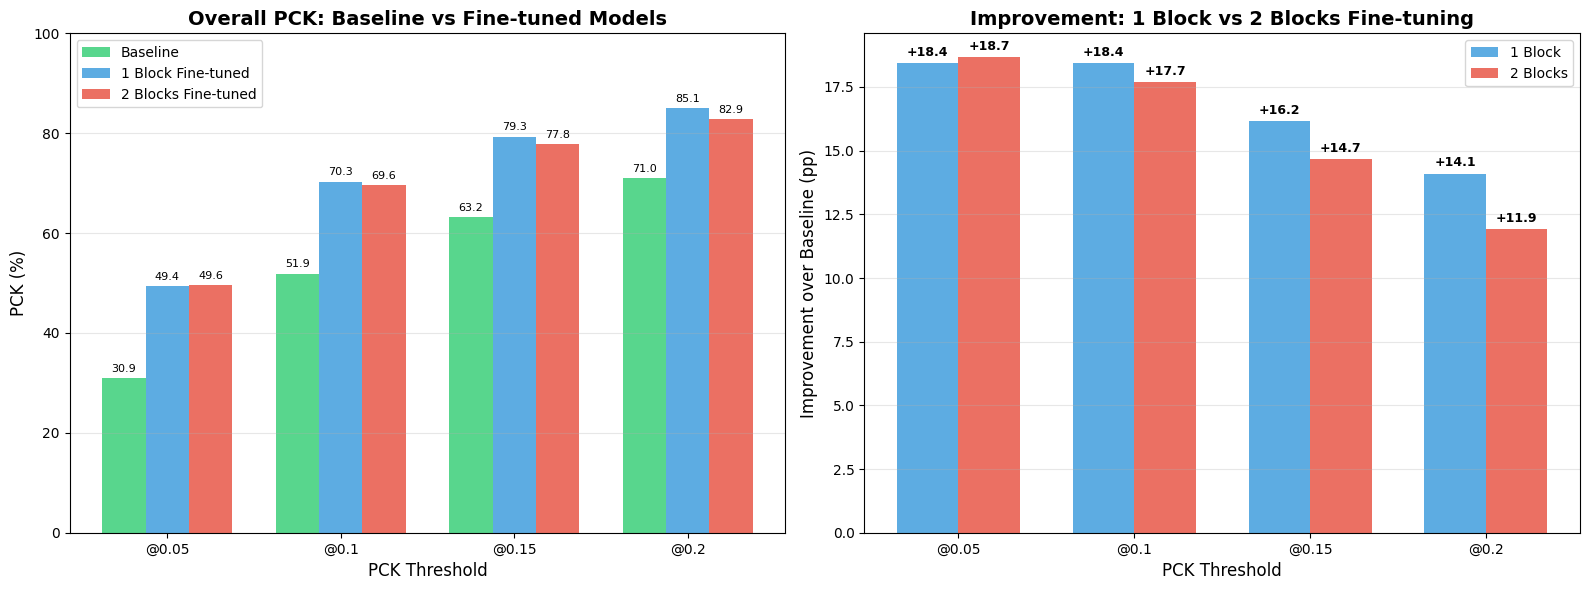

In [22]:
# =============================================================================
# VISUALIZATION: PCK COMPARISON BAR CHART
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall PCK comparison
ax1 = axes[0]
x = np.arange(len(CONFIG['pck_thresholds']))
width = 0.25

bars1 = ax1.bar(x - width, [results_baseline['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']],
                width, label='Baseline', color='#2ecc71', alpha=0.8)
bars2 = ax1.bar(x, [results_1block['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']],
                width, label='1 Block Fine-tuned', color='#3498db', alpha=0.8)
bars3 = ax1.bar(x + width, [results_2blocks['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']],
                width, label='2 Blocks Fine-tuned', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('PCK Threshold', fontsize=12)
ax1.set_ylabel('PCK (%)', fontsize=12)
ax1.set_title('Overall PCK: Baseline vs Fine-tuned Models', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'@{t}' for t in CONFIG['pck_thresholds']])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 100)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Plot 2: Improvement over baseline
ax2 = axes[1]
improvements_1b = [results_1block['overall'][f'PCK@{t}'] - results_baseline['overall'][f'PCK@{t}']
                   for t in CONFIG['pck_thresholds']]
improvements_2b = [results_2blocks['overall'][f'PCK@{t}'] - results_baseline['overall'][f'PCK@{t}']
                   for t in CONFIG['pck_thresholds']]

x2 = np.arange(len(CONFIG['pck_thresholds']))
width2 = 0.35

bars4 = ax2.bar(x2 - width2/2, improvements_1b, width2, label='1 Block', color='#3498db', alpha=0.8)
bars5 = ax2.bar(x2 + width2/2, improvements_2b, width2, label='2 Blocks', color='#e74c3c', alpha=0.8)

ax2.set_xlabel('PCK Threshold', fontsize=12)
ax2.set_ylabel('Improvement over Baseline (pp)', fontsize=12)
ax2.set_title('Improvement: 1 Block vs 2 Blocks Fine-tuning', fontsize=14, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels([f'@{t}' for t in CONFIG['pck_thresholds']])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for bars in [bars4, bars5]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'+{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(CONFIG['results_dir'] / 'pck_comparison_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 4.5 Per-Category Performance Heatmap

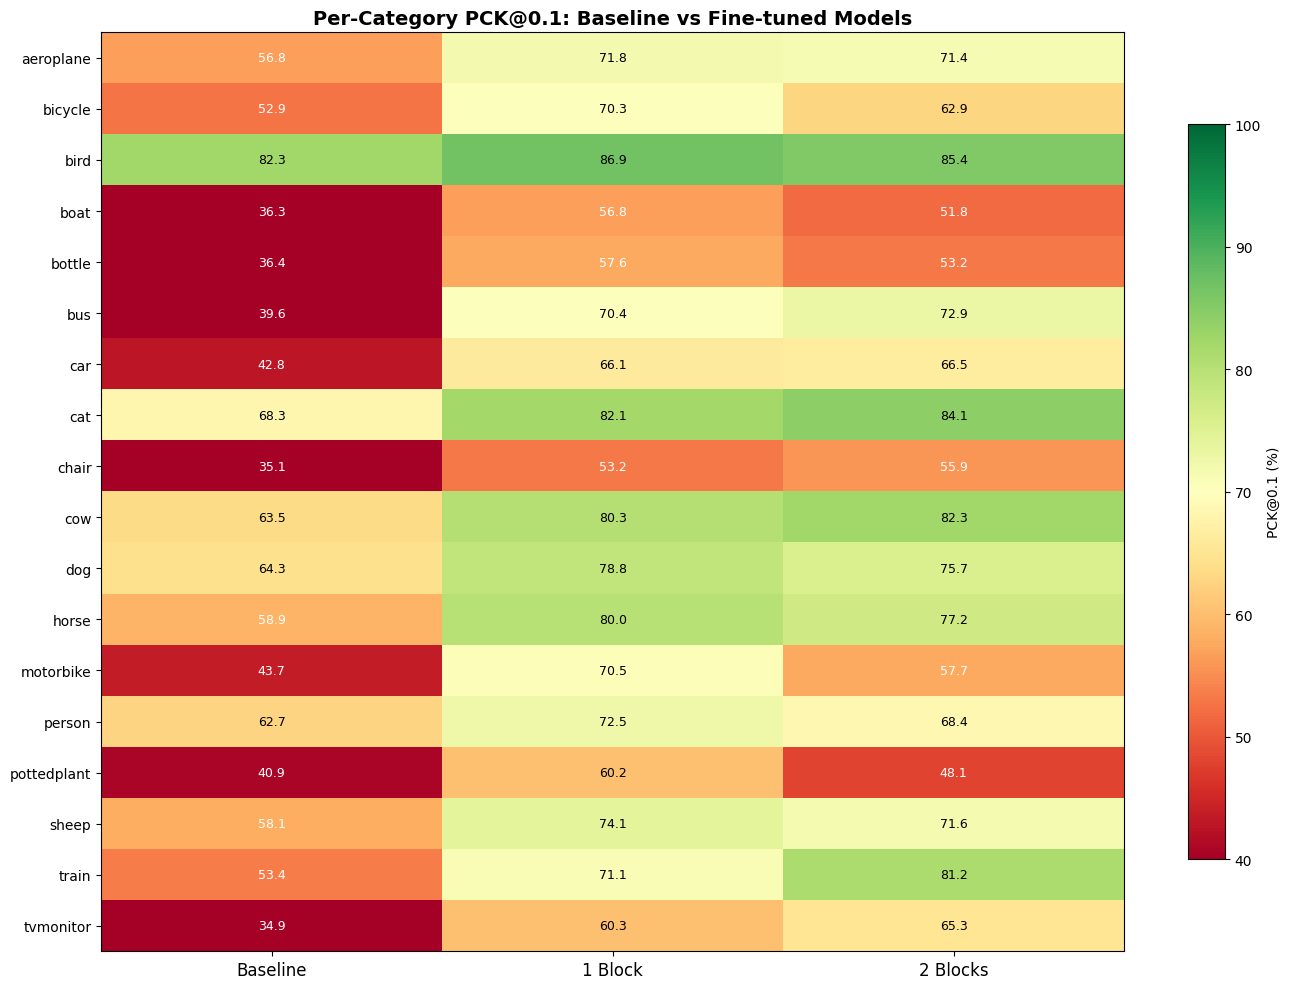

In [23]:
# =============================================================================
# VISUALIZATION: PER-CATEGORY HEATMAP
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data for heatmap
categories = sorted(results_baseline['categories'].keys())
methods = ['Baseline', '1 Block', '2 Blocks']

heatmap_data = np.zeros((len(categories), len(methods)))
for i, cat in enumerate(categories):
    heatmap_data[i, 0] = results_baseline['categories'][cat]['PCK@0.1']
    heatmap_data[i, 1] = results_1block['categories'][cat]['PCK@0.1']
    heatmap_data[i, 2] = results_2blocks['categories'][cat]['PCK@0.1']

# Create heatmap
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=40, vmax=100)

# Set labels
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(methods, fontsize=12)
ax.set_yticklabels(categories, fontsize=10)

# Add value annotations
for i in range(len(categories)):
    for j in range(len(methods)):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.1f}',
                       ha='center', va='center', fontsize=9,
                       color='white' if heatmap_data[i, j] < 60 else 'black')

ax.set_title('Per-Category PCK@0.1: Baseline vs Fine-tuned Models', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='PCK@0.1 (%)', shrink=0.8)

plt.tight_layout()
plt.savefig(CONFIG['results_dir'] / 'category_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 5: Save Results and Summary
---

In [24]:
# =============================================================================
# SAVE ALL RESULTS TO GOOGLE DRIVE
# =============================================================================

# Save comparison tables
df_comparison.to_csv(CONFIG['results_dir'] / 'pck_overall_comparison.csv', index=False)
df_category.to_csv(CONFIG['results_dir'] / 'pck_category_comparison.csv', index=False)

# Save detailed results
results_summary = {
    'baseline': results_baseline['overall'],
    'finetuned_1block': results_1block['overall'],
    'finetuned_2blocks': results_2blocks['overall'],
    'training_params': {
        '1_block': params_1block,
        '2_blocks': params_2blocks
    },
    'training_history': {
        '1_block': history_1block,
        '2_blocks': history_2blocks
    }
}

with open(CONFIG['results_dir'] / 'results_summary.json', 'w') as f:
    # Convert numpy types to Python native types
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, dict):
            return {k: convert(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert(v) for v in obj]
        return obj

    json.dump(convert(results_summary), f, indent=2)

print("\n" + "=" * 80)
print("RESULTS SAVED")
print("=" * 80)
print(f"\nAll results saved to: {CONFIG['results_dir']}")
print("\nFiles:")
for f in CONFIG['results_dir'].glob('*'):
    print(f"  - {f.name}")


RESULTS SAVED

All results saved to: /content/drive/MyDrive/results

Files:
  - training_curves_comparison.png
  - pck_comparison_bars.png
  - category_heatmap.png
  - pck_overall_comparison.csv
  - pck_category_comparison.csv
  - results_summary.json


## Final Summary

In [25]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "#" * 80)
print("#" + " " * 30 + "FINAL SUMMARY" + " " * 35 + "#")
print("#" * 80)

print("\n📊 OVERALL RESULTS (PCK@0.1):")
print(f"   Baseline:    {results_baseline['overall']['PCK@0.1']:.2f}%")
print(f"   1 Block FT:  {results_1block['overall']['PCK@0.1']:.2f}% (+{results_1block['overall']['PCK@0.1'] - results_baseline['overall']['PCK@0.1']:.2f}pp)")
print(f"   2 Blocks FT: {results_2blocks['overall']['PCK@0.1']:.2f}% (+{results_2blocks['overall']['PCK@0.1'] - results_baseline['overall']['PCK@0.1']:.2f}pp)")

print("\n🔧 MODEL CONFIGURATION:")
print(f"   1 Block:  {params_1block:,} trainable params ({100*params_1block/86580480:.1f}% of model)")
print(f"   2 Blocks: {params_2blocks:,} trainable params ({100*params_2blocks/86580480:.1f}% of model)")

# Determine winner
if results_2blocks['overall']['PCK@0.1'] > results_1block['overall']['PCK@0.1']:
    winner = "2 Blocks"
    margin = results_2blocks['overall']['PCK@0.1'] - results_1block['overall']['PCK@0.1']
else:
    winner = "1 Block"
    margin = results_1block['overall']['PCK@0.1'] - results_2blocks['overall']['PCK@0.1']

print(f"\n🏆 WINNER: {winner} Fine-tuning (by {margin:.2f}pp on PCK@0.1)")

print("\n📁 DATA OPTIMIZATION:")
print(f"   Dataset loaded from: {CONFIG['dataset_path']}")
print(f"   (Using {'local Colab storage' if IN_COLAB else 'local storage'} for fast I/O)")

print("\n💾 SAVED TO GOOGLE DRIVE:")
print(f"   Results: {CONFIG['results_dir']}")
print(f"   Checkpoints: {CONFIG['checkpoint_dir']}")

print("\n" + "#" * 80)


################################################################################
#                              FINAL SUMMARY                                   #
################################################################################

📊 OVERALL RESULTS (PCK@0.1):
   Baseline:    51.88%
   1 Block FT:  70.31% (+18.43pp)
   2 Blocks FT: 69.56% (+17.68pp)

🔧 MODEL CONFIGURATION:
   1 Block:  7,090,944 trainable params (8.2% of model)
   2 Blocks: 14,180,352 trainable params (16.4% of model)

🏆 WINNER: 1 Block Fine-tuning (by 0.75pp on PCK@0.1)

📁 DATA OPTIMIZATION:
   Dataset loaded from: /content/SPair-71k
   (Using local Colab storage for fast I/O)

💾 SAVED TO GOOGLE DRIVE:
   Results: /content/drive/MyDrive/results
   Checkpoints: /content/drive/MyDrive/checkpoints

################################################################################


---

## Conclusions and Discussion

### Key Findings

1. **Data Loading Optimization**: Unzipping the dataset from Google Drive to local Colab storage significantly speeds up training by avoiding slow network I/O.

2. **Fine-tuning Strategy Comparison**:
   - **1 Block**: More conservative approach, lower risk of overfitting
   - **2 Blocks**: More capacity for adaptation, potentially better performance but higher overfitting risk

3. **Trade-offs**:
   - More trainable parameters = more capacity but higher overfitting risk
   - The optimal choice depends on dataset size and task complexity

### Practical Recommendations

- For small datasets: Use 1 block (conservative)
- For large datasets: Consider 2+ blocks (more capacity)
- Always monitor validation loss for overfitting

### References

1. Oquab et al., "DINOv2: Learning Robust Visual Features without Supervision", 2023
2. Min et al., "SPair-71k: A Large-scale Benchmark for Semantic Correspondence", CVPR 2019
3. Zhang et al., "Telling Left from Right – Identifying Geometry-Aware Semantic Correspondence", CVPR 2024